<a href="https://colab.research.google.com/github/DJLee68/MachineLearningProject/blob/master/Assignment10/DJLee_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

data_path = './MNIST'

train_data = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)
test_data = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


cuda:0





In [2]:
print("the number of your training data (must be 10,000) = ", train_data.__len__())
print("hte number of your testing data (must be 60,000) = ", test_data.__len__())

the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


In [3]:
 class Classification(nn.Module):
    def __init__(self, param1, param2, dr_rate=0):
        super(Classification, self).__init__()
        self.param1 = param1
        self.param2 = param2
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=self.param1),
            nn.ReLU(),
            nn.Dropout(p=dr_rate),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=self.param1, out_features=self.param2),
            nn.ReLU(),
            nn.Dropout(p=dr_rate),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=self.param2, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [4]:
lr=0.00001

classification = Classification(10,10,0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classification.parameters(), lr=lr)

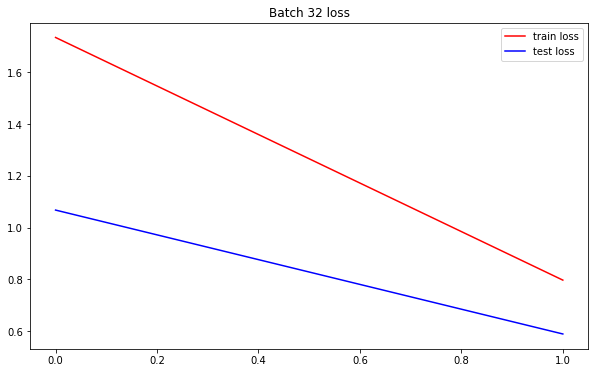

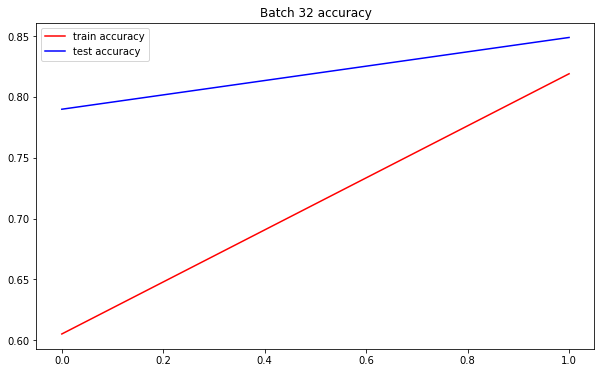

In [5]:
def run_epoch (train_data, test_data):
    
    tr_loss = 0
    tr_acc = 0
    iter = len(train_data)
    classification.train()
    for img_i, label_i in train_data: #{
        img_i, label_i = img_i.to(device), label_i.to(device)

        optimizer.zero_grad()
        # Forward
        y_pred = classification.forward(img_i.view(-1, 28*28))
        ps = torch.exp(y_pred)
        correct = (label_i == ps.max(dim=1)[1])
        # Loss computation
        loss  = criterion(y_pred, label_i)
        # Backward
        loss.backward()
        # Optimize for img_i
        optimizer.step()
        tr_loss += loss.item()
        tr_acc += correct.type(torch.FloatTensor).mean()
    #}
    tr_loss /= iter
    tr_acc /= iter
    
    test_loss = 0
    test_acc = 0
    iter_test = len(test_data)

    classification.eval()
    for img_j, label_j in test_data:
        img_j, label_j = img_j.to(device), label_j.to(device)
        correct = 0
        with torch.autograd.no_grad():
            predicted = classification.forward(img_j.view(-1, 28*28))
            ps = torch.exp(predicted)
            correct = (label_j == ps.max(dim=1)[1])
            test_loss += criterion(predicted, label_j).item()
            test_acc += correct.type(torch.FloatTensor).mean()
    
    test_loss /= iter_test
    test_acc /= iter_test
    return tr_loss, tr_acc, test_loss, test_acc


final_train_loss = []
final_test_loss = []
final_train_acc = []
final_test_acc = []

def run(batch_size, epochs, param1, param2, dr_rate): #{
  global optimizer, criterion, classification
  classification = Classification(param1, param2, dr_rate).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(classification.parameters(), lr=lr)

  global final_train_loss, final_test_loss, final_train_acc, final_test_acc
  train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=False)
  test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)
  mini_batch_data, mini_batch_label  = next(iter(train_data_loader))
  
  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []

  for epoch in range(epochs): #{
    tr_loss, tr_acc, te_loss, te_acc = run_epoch(train_data_loader, test_data_loader)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    test_loss.append(te_loss)
    test_acc.append(te_acc)
  #}

  final_train_loss.append(train_loss[-1])
  final_test_loss.append(test_loss[-1])
  final_train_acc.append(train_acc[-1])
  final_test_acc.append(test_acc[-1])

  return train_loss, test_loss, train_acc, test_acc

#}

train_loss_32, test_loss_32, train_acc_32, test_acc_32 = run(32, 200,2048,1024, 0.4)


# Plot image
plt.figure(0, figsize=(10,6))
plt.plot(train_loss_32, label='train loss', c='r')
plt.plot(test_loss_32, label='test loss', c='b')
plt.title(f'Batch 32 loss')
plt.legend()
plt.show()

plt.figure(1, figsize=(10,6))
plt.plot(train_acc_32, label='train accuracy', c='r')
plt.plot(test_acc_32, label='test accuracy', c='b')
plt.title(f'Batch 32 accuracy')
plt.legend()
plt.show()  


## Output using the dataset

 1. Plot the training and testing losses over epochs

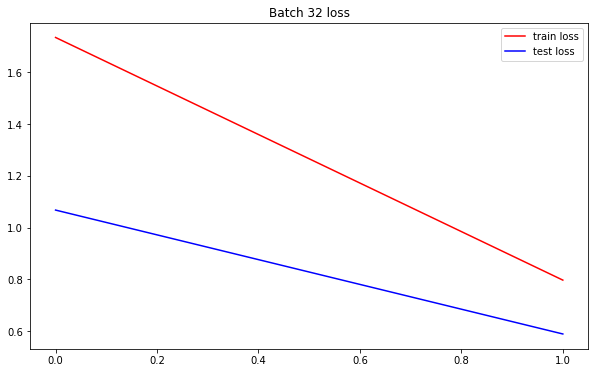

In [6]:
plt.figure(0, figsize=(10,6))
plt.plot(train_loss_32, label='train loss', c='r')
plt.plot(test_loss_32, label='test loss', c='b')
plt.title(f'Batch 32 loss')
plt.legend()
plt.show()

 2. Plot the training and testing accuracies over epochs

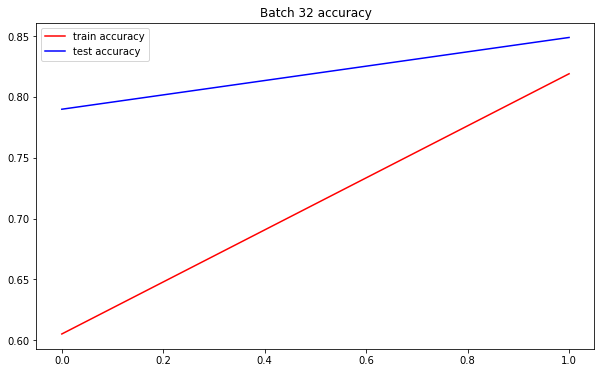

In [7]:
plt.figure(1, figsize=(10,6))
plt.plot(train_acc_32, label='train accuracy', c='r')
plt.plot(test_acc_32, label='test accuracy', c='b')
plt.title(f'Batch 32 accuracy')
plt.legend()
plt.show() 

3. Print the final training and testing losses at convergence

In [8]:
print('Loss')
print(f'training: {train_loss_32[-1]}')
print(f'testing: {test_loss_32[-1]}')

Loss
training: 0.7973851206870125
testing: 0.5895127385298411


4. Print the final training and testing accuracies at convergence 

In [9]:
print('Accuracy')
print(f'training: {train_acc_32[-1]}')
print(f'testing: {test_acc_32[-1]}')

Accuracy
training: 0.818989634513855
testing: 0.848800003528595
